# Project overview
Imagine you are working on the data team for a popular digital music service similar to Spotify or Pandora. Many of users stream their favorite songs to your service every day either using the free tier that place advertisements between the songs or using the premium subscription model, where they stream music as free but pay a monthly flat rate.

Users can upgrade, downgrade, or cancel their service at any time. So, it's crucial to make sure your users love the service. Every time a user interacts with the service while they're playing songs, logging out, like in a song with a thumbs up, hearing an ad, or downgrading their service, it generates data. All this data contains the key insights for keeping your users happy and helping your business thrive. (The full dataset is 12GB)

It's your job on the data team to predict which users are at risk to churn either downgrading from premium to free tier or cancelling their service altogether. If you can accurately identify these users before they leave, your business can offer them discounts and incentives, potentially saving your business millions in revenue.

To tackle this project, you will need to load, explorer, and clean this dataset with Spark. Based on your explanation, you will create features and build models with Spark to predict which users were churn from your digital music service.


Predicting churn rates is a challenging and common problem that data scientists and analysts regularly encounter in any customer-facing business. Additionally, the ability to efficiently manipulate large datasets with Spark is one of the highest-demand skills in the field of data.

# Problem Statement
* Load large datasets into Spark and manipulate them using Spark SQL and Spark Dataframes
* Gain insight of data set for better understanding (Data Exploration, Data Visualization etc.)
* Data preprocessing
* Use the machine learning APIs within Spark ML to build and tune models
* Predicting which users are at risk to churn and validate predict result

# Metrics
Some of the metrics we might use:
* Accuracy, recall, prescision, fmeasure(f1 socre)
* Coefficient

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini-sparkify-event-data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [1]:
# import libraries
# refer 'https://changhsinlee.com/install-pyspark-windows-jupyter/#comment-4302741820'
import findspark
findspark.init()

import time
import numpy as np
import zipfile
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.base import clone
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import *
import matplotlib.pyplot as plt
from pyspark.ml.feature import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier,LinearSVC

plt.rcParams['figure.figsize']=(15,5)

In [2]:
# upzip files
with zipfile.ZipFile("data_zip/mini_sparkify_event_data.zip",'r') as zf:
    zf.extractall("../Sparkify--Pyspark-Big-Data-Project")

In [196]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()
# Read in full sparkify dataset
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [4]:
# df schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# check for differnet pages
df.createOrReplaceTempView('t1')
spark.sql('''
select distinct page
from t1''').show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [6]:
# check for different userAgent
spark.sql('''
select distinct userAgent
from t1
''').show(20,False)

+-------------------------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                 |
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                   |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                                 |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                 |
|"Mozi

###### clean userAgent column

Detailed sub-categories on userAgent is not useful for aggregation and analytical purpose. Instead We will only keep system information.

In [7]:
# remove ""
df=df.withColumn("userAgent",regexp_replace('userAgent','"',''))
# remove Mozilla/5.0 
df=df.withColumn("userAgent",regexp_replace('userAgent','Mozilla/5.0 ',''))

In [8]:
# tokenize userAgent
regexTokenizer =RegexTokenizer(inputCol='userAgent',outputCol='words',pattern="\\W")
df=regexTokenizer.transform(df)

In [9]:
# keep first element in words column
df=df.withColumn('OS',df.words[0].cast(StringType())).drop('words')

In [10]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='(Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', OS='windows')

In [11]:
df.createOrReplaceTempView('t1')
spark.sql('''
select count(distinct userAgent)
from t1
''').show()

+-------------------------+
|count(DISTINCT userAgent)|
+-------------------------+
|                       56|
+-------------------------+



###### check missing values for column userId and sessionId

In [12]:
# records without userids or sessionids
spark.sql('''
select *
from t1
where sessionId is null or userId is null''').show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+---+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId| OS|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+---+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+---+



> There are no Nan values in either column

In [13]:
# check empty userids
spark.sql('''
select distinct userId
from t1
order by 1''').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



> However there are empty userids

In [15]:
# empty userid recrods characteristics
spark.sql('''
select distinct auth, page
from t1
where userId =""
''').show()

+----------+-------------------+
|      auth|               page|
+----------+-------------------+
|Logged Out|               Home|
|     Guest|           Register|
|Logged Out|              Error|
|     Guest|              About|
|     Guest|              Error|
|Logged Out|              Login|
|Logged Out|               Help|
|     Guest|Submit Registration|
|Logged Out|              About|
|     Guest|               Help|
|     Guest|               Home|
+----------+-------------------+



> Empty userId records have majority features as NaN, uers didn't listen to any music. We will drop these rows.

In [16]:
df=spark.sql('''
select *
from t1
where userId !=""
''')
df.count()

278154

###### clean location column

Location provides detailed sub-categories, which doesn't provide district level geographic data distribution. Instead we will keep the state abbreviation only so that we can aggregate data by states.

In [17]:
# check different locations
spark.sql('''
select distinct location
from t1
''').show(10,False)

+--------------------------------------+
|location                              |
+--------------------------------------+
|Gainesville, FL                       |
|Atlantic City-Hammonton, NJ           |
|Deltona-Daytona Beach-Ormond Beach, FL|
|San Diego-Carlsbad, CA                |
|Cleveland-Elyria, OH                  |
|Kingsport-Bristol-Bristol, TN-VA      |
|New Haven-Milford, CT                 |
|Birmingham-Hoover, AL                 |
|Corpus Christi, TX                    |
|Dubuque, IA                           |
+--------------------------------------+
only showing top 10 rows



In [18]:
# check distinct amount
spark.sql('''
select count(distinct location)
from t1
''').show()

+------------------------+
|count(DISTINCT location)|
+------------------------+
|                     114|
+------------------------+



In [19]:
# keep state abb only
state=udf(lambda x: x.strip().split(', ')[-1])
df=df.withColumn('location',state(df.location))

In [20]:
# check distinct amount of state abb
df.select('location').dropDuplicates().count()

58

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


In [22]:
df.createOrReplaceTempView('t1')
print("amount of people stay (without Cancellation Confirmation status)")
spark.sql('''
select count(distinct userId)
from t1
where userId not in (
select distinct userId
from t1
where page="Cancellation Confirmation")
''').show()

amount of people stay (without Cancellation Confirmation status)
+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   173|
+----------------------+



In [23]:
print("amount of people chruned (with Cancellation Confirmation status)")
spark.sql('''
select count(distinct userId)
from t1
where page="Cancellation Confirmation"
''').show()

amount of people chruned (with Cancellation Confirmation status)
+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                    52|
+----------------------+



In [24]:
# flag 'Cancellation Confirmation' status
df.createOrReplaceTempView('t1')
spark.udf.register("churn", lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())
df=spark.sql('''
select *, sum(churn(page))over(partition by userId) Churn
from t1
''')

In [25]:
# check result
df.createOrReplaceTempView('t1')
spark.sql('''
select Churn, count(*)
from t1
group by 1''').show()

+-----+--------+
|Churn|count(1)|
+-----+--------+
|    0|  233290|
|    1|   44864|
+-----+--------+



In [26]:
233290/44864

5.1999375891583455

> Our label on Churn is 1:5.2. This may cause imblance data problem for mechine learning procedure.

###### Wrangling pipeline

In [199]:
def cleanpipe(df=df):
    '''
    clean df pipeline. Columns cleaned:
    userAgent- keep operating system info only
    userId- remove empty userId
    location- keep state info only
    input: dataframe need to be cleand
    output: a cleaned dataframe'''
    
    ## userAgent
    # remove ""
    df=df.withColumn("userAgent",regexp_replace('userAgent','"',''))
    # remove Mozilla/5.0 
    df=df.withColumn("userAgent",regexp_replace('userAgent','Mozilla/5.0 ',''))
    # tokenize userAgent
    regexTokenizer =RegexTokenizer(inputCol='userAgent',outputCol='words',pattern="\\W")
    df=regexTokenizer.transform(df)
    # keep first element in words column
    df=df.withColumn('OS',df.words[0].cast(StringType())).drop('words')
    
    ## userId
    df.createOrReplaceTempView('t1')
    df=spark.sql('''
    select *
    from t1
    where userId !=""
    ''')
    
    ## location
    # keep state abb only
    state=udf(lambda x: x.strip().split(', ')[-1])
    df=df.withColumn('location',state(df.location))
    
    ## flag 'Cancellation Confirmation' status
    spark.udf.register("churn", lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())
    df=spark.sql('''
    select *, sum(churn(page))over(partition by userId) Churn
    from t1
    ''')
    
    return df

In [200]:
df=cleanpipe()
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='(iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53', userId='100010', OS='iphone', Churn=0)


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

###### Churn rate vs gender

In [27]:
df.createOrReplaceTempView("churnsex")
churnsex=spark.sql('''
select gender, avg(Churn) churn_rate
from (
select distinct userId,gender,Churn
from churnsex) temp
group by 1
''').toPandas()

In [28]:
churnsex

,gender,churn_rate
0,F,0.192308
1,M,0.264463


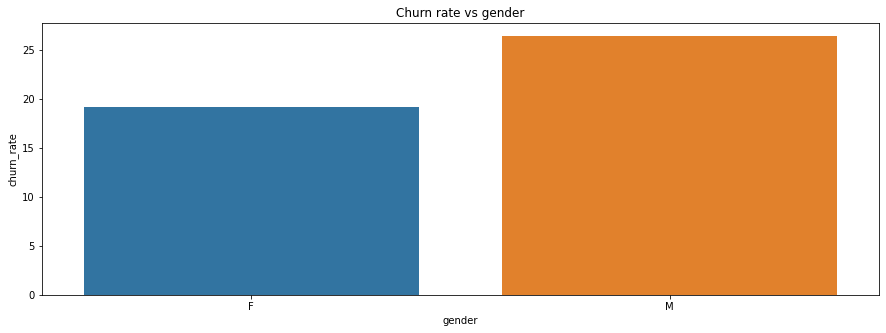

In [29]:
sns.barplot(churnsex['gender'],100*churnsex['churn_rate'])
plt.title('Churn rate vs gender');

> We can see that male churn rate is higher than female. 26.4% VS. 19.2% to be specific.

###### churn rate vs location

In [30]:
df.createOrReplaceTempView("chrunstate")
chrunstate=spark.sql('''
select location, avg(Churn) churn_rate
from (
    select distinct userId,location,Churn
    from chrunstate) temp
group by 1
having avg(Churn)>0
order by 2 desc, 1
''').toPandas()

In [31]:
# user amount vs churn user amount every location
chruncountstate=spark.sql('''
select distinct userId,location,Churn
from chrunstate
order by 2
''').toPandas()

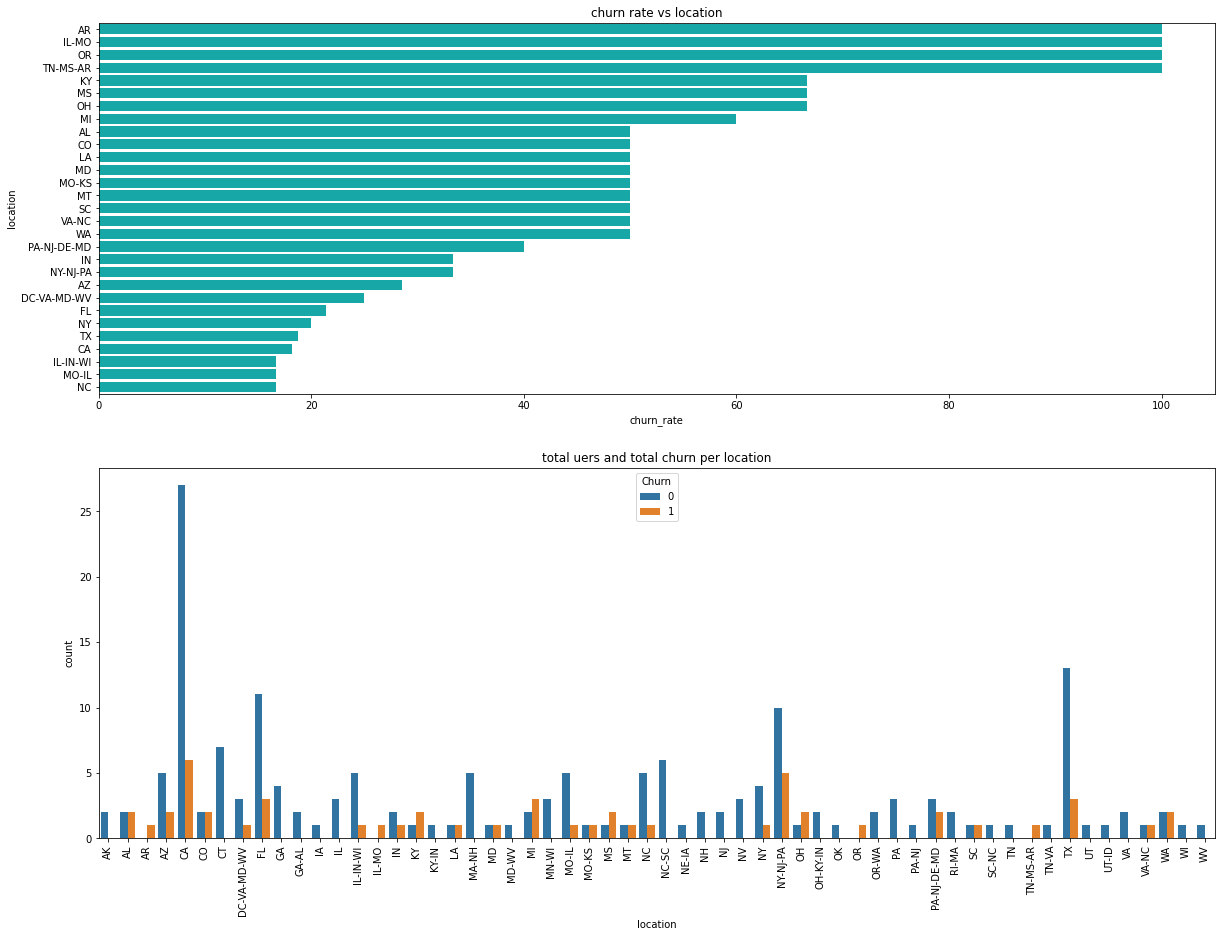

In [32]:
plt.figure(figsize=(20,15))
plt.subplot(211)
sns.barplot(100*chrunstate['churn_rate'],chrunstate['location'],color='c')
plt.title('churn rate vs location')

plt.subplot(212)
sns.countplot(data=chruncountstate,x='location',hue='Churn')
plt.title('total uers and total churn per location')
plt.xticks(rotation=90);

> Here we can see churn ratio per location as well as uers/churn users count per location. One thing worth to notice, even though some of the state has a high churn ratio, it might due to the fact the user base is really small. Vice versa. 

> E.g. AR's churn rate is 100% because it has a total amount of 1 users while 1 churned.

###### Churn status vs avg amount of songs listened
###### Churn status vs avg amount of listen time (in hours)

In [33]:
# Churn status vs avg amount of songs listened
df.createOrReplaceTempView('avgsong')
avgsongpersuer=spark.sql('''
select Churn, count(song)/count(distinct userId) avgsongpersuer
from avgsong
group by 1''').toPandas()
avgsongpersuer

,Churn,avgsongpersuer
0,0,1108.173410
1,1,699.884615


In [34]:
# Churn status vs avg amount of listen time (in hours)
avgtime=spark.sql('''
select Churn, sum(length)/count(distinct userId)/60/60 avgtimepersuer
from avgsong
group by 1''').toPandas()
avgtime

,Churn,avgtimepersuer
0,0,76.713038
1,1,48.337297


In [35]:
# casster
hrssongs=spark.sql('''
select distinct userId, Churn, round(sum(length)/60/60,2) hrs, count(song) songs
from avgsong
group by 1,2''').toPandas()
hrssongs

,userId,Churn,hrs,songs
0,100010,0,18.59,275
1,200002,0,26.11,387
2,125,1,0.58,8
3,124,0,281.20,4079
4,51,1,145.35,2111
...,...,...,...,...
220,45,0,101.98,1484
221,57,0,5.90,92
222,200021,1,83.53,1227
223,119,0,12.42,173


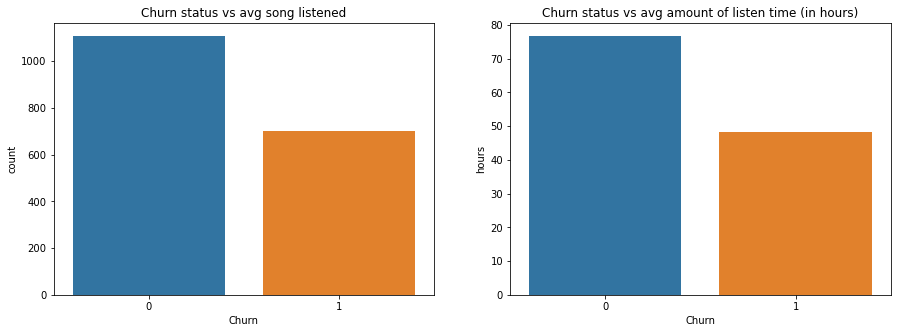

In [36]:
plt.subplot(121)
sns.barplot(avgsongpersuer['Churn'],avgsongpersuer['avgsongpersuer'])
plt.title('Churn status vs avg song listened')
plt.ylabel('count')

plt.subplot(122)
sns.barplot(avgtime['Churn'],avgtime['avgtimepersuer'])
plt.title('Churn status vs avg amount of listen time (in hours)')
plt.ylabel("hours");

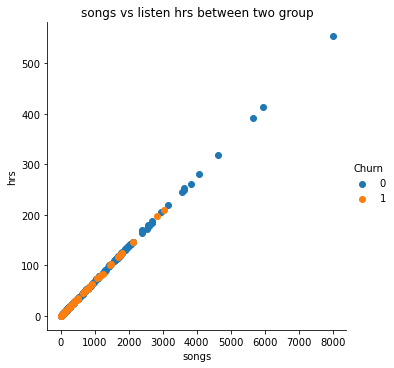

In [37]:
g=sns.FacetGrid(data=hrssongs, hue='Churn',height=5)
g.map(plt.scatter,'songs','hrs')
g.add_legend()
plt.title('songs vs listen hrs between two group');

In [38]:
print("Difference of amount of songs between two groups is:",
int(avgsongpersuer['avgsongpersuer'].max()-avgsongpersuer['avgsongpersuer'].min()))

Difference of amount of songs between two groups is: 408


In [39]:
print("Difference of amount of listen time between two groups is {:.2f} hrs"
      .format(avgtime['avgtimepersuer'].max()-avgtime['avgtimepersuer'].min()))

Difference of amount of listen time between two groups is 28.38 hrs


> We can see a trend that user who stayed listend 408 more songs on average than the ones who churned. User who stayed spent 28.38 hours more than user who churned on listening musics. Scatter plot indicates the relationships.

###### Song length proportional distribution by churn group

In [40]:
churnedlen=spark.sql('''
select length
from avgsong
where Churn=1''').toPandas()

staylen=spark.sql('''
select length
from avgsong
where Churn=0''').toPandas()

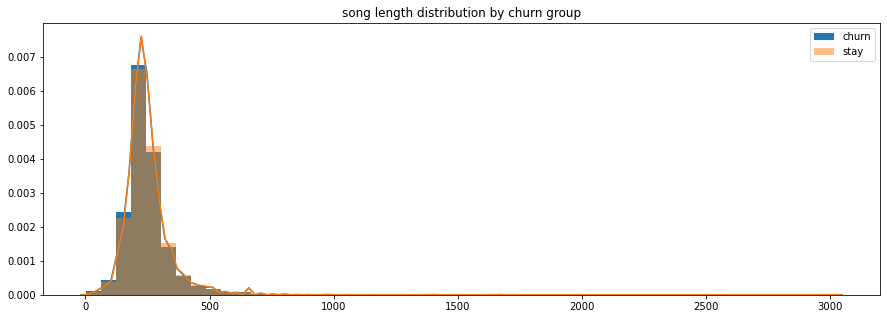

In [41]:
sns.distplot(churnedlen,label='churn',hist_kws={'alpha':1})
sns.distplot(staylen,label='stay',hist_kws={'alpha':.5})
plt.legend(loc=0)
plt.title('song length distribution by churn group')
plt.show();

> In term of proportional distributions of lengths of songs listened by two cohorts, they are very similar.
###### Status 404 distribution between cohorts

In [42]:
status=spark.sql('''
select status, Churn, count(status)/count(distinct userId) ratio
from avgsong
where status='404'
group by 1,2''').toPandas()

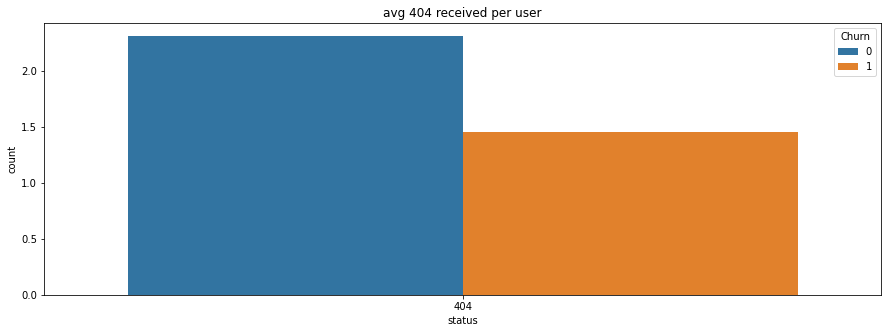

In [43]:
sns.barplot(data=status,x='status',y='ratio',hue='Churn')
plt.ylabel('count')
plt.title('avg 404 received per user');

In [44]:
status

,status,Churn,ratio
0,404,0,2.315789
1,404,1,1.454545


> To inspect if user churn due to HTTP technical reason, we can check average 404 message received per user in each group. User who stayed receive more than 2 per person while user churned receive less than 1.5. This indicates status may not be a strong causation.
###### Page distributions in each group

In [45]:
page=spark.sql('''
select Churn,page, count(userId)/count(distinct userId) avg_interaction
from avgsong
group by 1,2
order by 2,1''').toPandas()

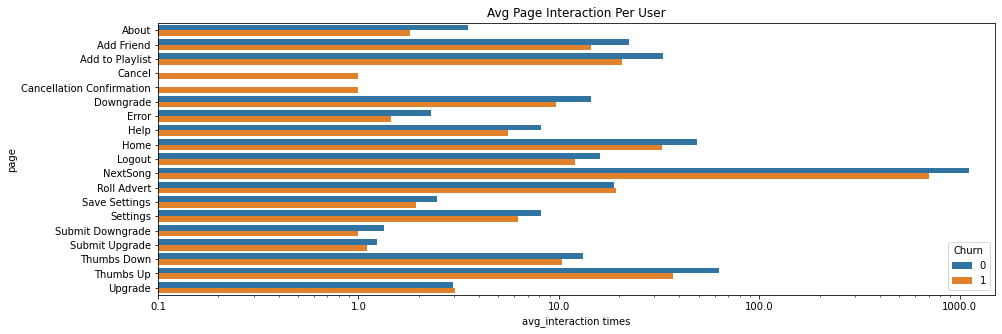

In [46]:
sns.barplot(y=page['page'],x=page['avg_interaction'],hue=page['Churn'])
plt.xscale('log')
locs, labels=plt.xticks()
plt.xticks(ticks=locs,labels=locs)
plt.xlim(.1,1500)
plt.title('Avg Page Interaction Per User')
plt.xlabel('avg_interaction times');

In [47]:
print("Roll Advert difference between two cohorts is :",page.query("page=='Roll Advert'")['avg_interaction'].diff()[21])

Roll Advert difference between two cohorts is : 0.448280254777071


In [48]:
print("Upgrade difference between two cohorts is :",page.query("page=='Upgrade'")['avg_interaction'].diff()[35])

Upgrade difference between two cohorts is : 0.0728285537445843


> Observing 'Avg Page Interaction Per User' plot, we can gain some interesting insights. Gerenally speaking, stayed users interact with app more than churned users. But we can see four page categories churned users interact more than stayed users. They are:
    * Cancel
    * Cancellation Confirmation
    * Roll Advert
    * Upgrade
> Regardless of cancel interactions, churned users have 0.45 more roll advert page than stayed user on average, could they churned because they received too many ads? Another interesting fact is churned uer land on Upgrade page more than stayed users even though the difference is really small (around 0.07). This might suggest more customers have considered upgrade account in churn cohort than stay cohort. But when we look at Submit Upgrade page interactions, stay cohort still higher than churned cohort, means convert rate of stayed users is higher than churned users, which make sense.
###### Operating system vs churn rate

In [49]:
oschurn=spark.sql('''
select OS,100*avg(Churn) churnrate
from (select distinct OS, userId, Churn
        from avgsong) temp
group by 1
order by 2 desc''').toPandas()
oschurn

,OS,churnrate
0,x11,41.666667
1,iphone,30.769231
2,windows,22.641509
3,macintosh,22.093023
4,compatible,0.000000
5,ipad,0.000000


In [50]:
spark.sql('''
select OS, count(distinct userId)
from avgsong
group by 1
order by 2 desc''').show()

+----------+----------------------+
|        OS|count(DISTINCT userId)|
+----------+----------------------+
|   windows|                   106|
| macintosh|                    86|
|    iphone|                    13|
|       x11|                    12|
|compatible|                     5|
|      ipad|                     3|
+----------+----------------------+



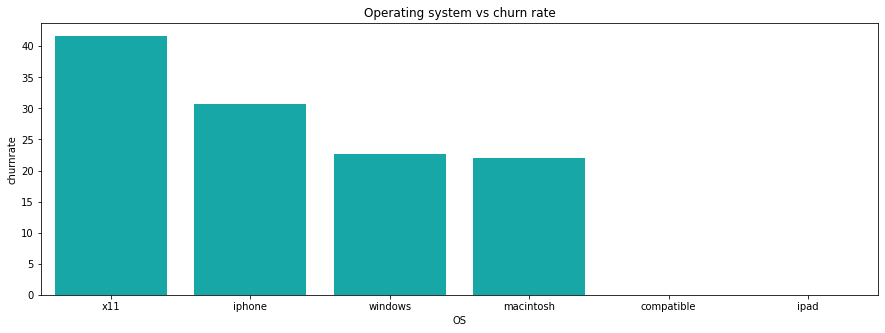

In [51]:
sns.barplot(data=oschurn,x='OS',y='churnrate',color='c')
plt.title('Operating system vs churn rate');

> The churn rate formula is: 
$$\frac{Number\ of\ Distinct\ Users\ Churned}{Total\ Distinct\ Users\ On\ OS}$$
> We can see on Linux x11 OS, the churn rate is over 40%, which indicates app UX might need to be improved on specific OS.
###### Time series analysis

In [52]:
# make a copy
timedf=df

In [53]:
# function to extract hour and weekday
get_hour=udf(lambda x: datetime.fromtimestamp(x/1000.0).hour)
get_weekday=udf(lambda x: datetime.fromtimestamp(x/1000.0).weekday())

In [54]:
# create new columns to store values
timedf=timedf.withColumn("hour",get_hour(df.ts).cast("float"))

timedf=timedf.withColumn("weekday",get_weekday(df.ts))

In [55]:
timedf.createOrReplaceTempView("timetable")
avgperhour=spark.sql('''
select hour, Churn, count(song)/count(distinct userId) avgperhour
from timetable
group by 1,2
order by 1,2''').toPandas()

In [56]:
avgperday=spark.sql('''
select weekday, Churn, count(song)/count(distinct userId) avgperday
from timetable
group by 1,2
order by 1,2''').toPandas()

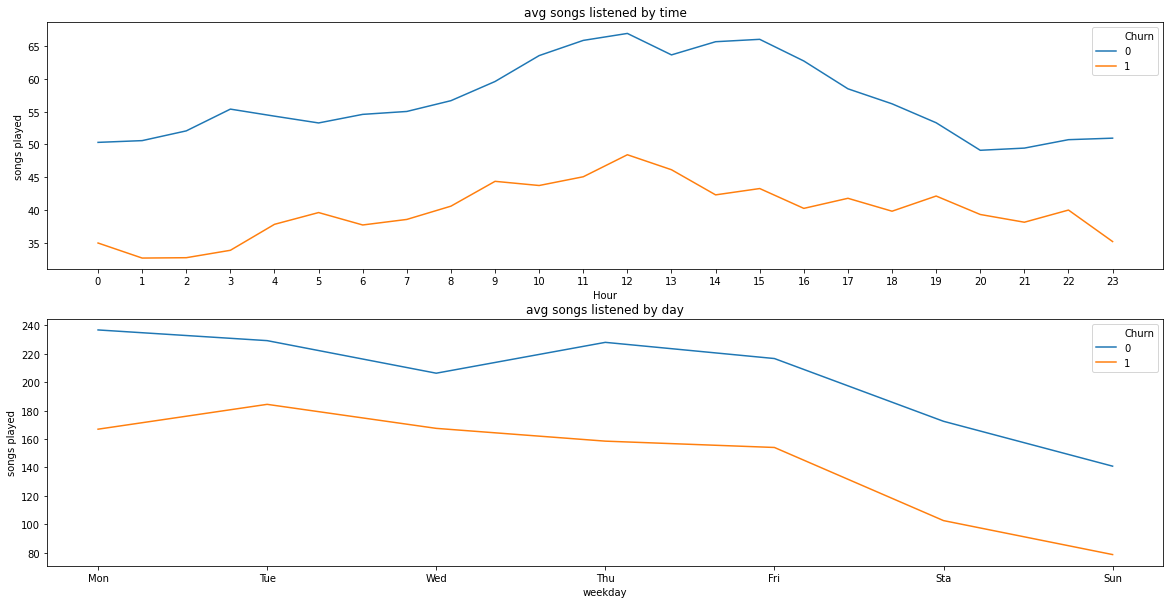

In [57]:
# avg songs listened by time
plt.figure(figsize=(20,10))
plt.subplot(211)
sns.lineplot(data=avgperhour,x='hour',y='avgperhour',hue='Churn')
ticks=np.arange(24)
plt.xticks(ticks=ticks,labels=ticks.tolist())
plt.title('avg songs listened by time')
plt.xlabel('Hour')
plt.ylabel('songs played')
plt.legend(loc=0)

# avg songs listened by day
plt.subplot(212)
sns.lineplot(data=avgperday,x='weekday',y='avgperday',hue='Churn')
ticks=np.arange(0,7)
labels=['Mon','Tue',"Wed",'Thu','Fri','Sta',"Sun"]
plt.xticks(ticks=ticks,labels=labels)
plt.title('avg songs listened by day')
plt.xlabel('weekday')
plt.ylabel('songs played')
plt.legend(loc=0);

> For hours of a day time analysis, we can see average songs played by distinct users in stayed group is higher than churned group. They both following a similar trend, users have the least interaction with app during 23 to next day 4 o'clock in the morning, this make perfect sense because of sleeping schedule. When some of users start to get ready for work or morning exercise, we can start to see a increase after 4. Both lines gradually increase until reach the peaks round 12 at noon, this might suggest users like to use the app during lunch break. We experience a slight drop after user go back to work after lunch, then we see a small peak right before or after people get off work, which is round 15. Our usage trends start to decrease as the day windind down, near the end of the day around 22 o'clock, we see a boost which suggest some users use the app before sleep.

> For weekday analysis, again user who stayed generally played more songs than users who churned, but user behaviors are slightly different between two groups. Start from Monday we can see a continues decrease until Wednesday for stayed cohort, then we see an increase from Wednesday to Thursday and gradually decrease toward weekend. However, churned cohort shows an increase from Monday to Tuesday and gradually decrease since then. Both groups experience a deep drop start from Friday all along until Monday. This indicates uers use app to play musics on a day-to-day base instead of weekend entertainments.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.


In [58]:
df_feature=df
df_feature.createOrReplaceTempView("featureeg")
df_feature.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- OS: string (nullable = true)
 |-- Churn: long (nullable = true)



> check edge cases

In [59]:
# one user multiple location
spark.sql('''
select userId
from featureeg
group by 1
having count(distinct location) !=1
''').show()

+------+
|userId|
+------+
+------+



In [60]:
# one user multiple OS
spark.sql('''
select distinct userId,count(distinct OS) 
from featureeg
group by 1
having count(distinct OS) !=1
''').show()

+------+------------------+
|userId|count(DISTINCT OS)|
+------+------------------+
+------+------------------+



###### categorical features
* gender
* location
* OS

In [61]:
def cat_engineer(df_feature):
    '''
    input: cleaned df
    output: df_cat-one hot encoded categorical features with unique userIds
    '''
    # create view
    df_feature.createOrReplaceTempView("featureeg")
    
    # select distinct records
    df_cat=spark.sql('''
            select distinct userId, gender, location, OS
            from featureeg
            ''').toPandas()
    # convert to pandas to get dummy variables
    df_cat=pd.get_dummies(df_cat,columns=['gender','location','OS'],drop_first=True)
    # convert back to spark
    df_cat=spark.createDataFrame(df_cat)
    return df_cat

In [62]:
df_cat=cat_engineer(df_feature)

In [63]:
df_cat.head()

Row(userId='133', gender_M=1, location_AL=0, location_AR=0, location_AZ=0, location_CA=1, location_CO=0, location_CT=0, location_DC-VA-MD-WV=0, location_FL=0, location_GA=0, location_GA-AL=0, location_IA=0, location_IL=0, location_IL-IN-WI=0, location_IL-MO=0, location_IN=0, location_KY=0, location_KY-IN=0, location_LA=0, location_MA-NH=0, location_MD=0, location_MD-WV=0, location_MI=0, location_MN-WI=0, location_MO-IL=0, location_MO-KS=0, location_MS=0, location_MT=0, location_NC=0, location_NC-SC=0, location_NE-IA=0, location_NH=0, location_NJ=0, location_NV=0, location_NY=0, location_NY-NJ-PA=0, location_OH=0, location_OH-KY-IN=0, location_OK=0, location_OR=0, location_OR-WA=0, location_PA=0, location_PA-NJ=0, location_PA-NJ-DE-MD=0, location_RI-MA=0, location_SC=0, location_SC-NC=0, location_TN=0, location_TN-MS-AR=0, location_TN-VA=0, location_TX=0, location_UT=0, location_UT-ID=0, location_VA=0, location_VA-NC=0, location_WA=0, location_WI=0, location_WV=0, OS_ipad=0, OS_iphone=0

###### numerical features
* Num of distinct artist
* Total length
* Num of songs played
* Num of 404 status received
* Customer lifetime $\ last\ ts-registration$
* page count

In [64]:
def num_engineer(df_feature):
    '''
    input: cleaned df
    output: df_num-aggregated numerical features with unique userIds
    '''
    # create view
    df_feature.createOrReplaceTempView("featureeg")
    # aggregation
    df_num=spark.sql('''
                select userId, count(distinct artist) artnum, sum(length) length, count(song) songs, max(ts)-max(registration) lt,
                        sum(case when status="404" then 1
                                else 0
                                end) 404received
                from featureeg
                group by 1
                ''')
    return df_num

In [65]:
df_num=num_engineer(df_feature)

In [66]:
df_num.head()

Row(userId='100010', artnum=252, length=66940.89734999997, songs=275, lt=4807612000, 404received=0)

In [67]:
def pagecount(df_feature):
    '''
    input: cleaned df
    output: df_page-aggregated numerical page counts with unique userIds
    '''
    # create view
    df_feature.createOrReplaceTempView("featureeg")
    
    # drop cancel and Cancellation Confirmation page
    # convert to pandas
    df_page=spark.sql('''
                    select userId, page
                    from featureeg
                    where page not in ("Cancel","Cancellation Confirmation")
                    ''').toPandas()
    # get dummies and aggregation
    df_page=pd.get_dummies(data=df_page,columns=['page'])
    df_page=df_page.groupby(['userId']).sum().reset_index()
    # convert back to spark
    df_page=spark.createDataFrame(df_page)
    return df_page

In [68]:
df_page=pagecount(df_feature)

In [69]:
df_page.head()

Row(userId='10', page_About=2.0, page_Add Friend=12.0, page_Add to Playlist=9.0, page_Downgrade=7.0, page_Error=0.0, page_Help=1.0, page_Home=30.0, page_Logout=11.0, page_NextSong=673.0, page_Roll Advert=1.0, page_Save Settings=1.0, page_Settings=7.0, page_Submit Downgrade=0.0, page_Submit Upgrade=0.0, page_Thumbs Down=4.0, page_Thumbs Up=37.0, page_Upgrade=0.0)

In [70]:
# join together
ml_df=df_feature.select('userId',col('Churn').alias('label')).dropDuplicates()\
        .join(df_cat,'userId')\
        .join(df_num,'userId')\
        .join(df_page,'userId')
ml_df.head()

Row(userId='100010', label=0, gender_M=0, location_AL=0, location_AR=0, location_AZ=0, location_CA=0, location_CO=0, location_CT=1, location_DC-VA-MD-WV=0, location_FL=0, location_GA=0, location_GA-AL=0, location_IA=0, location_IL=0, location_IL-IN-WI=0, location_IL-MO=0, location_IN=0, location_KY=0, location_KY-IN=0, location_LA=0, location_MA-NH=0, location_MD=0, location_MD-WV=0, location_MI=0, location_MN-WI=0, location_MO-IL=0, location_MO-KS=0, location_MS=0, location_MT=0, location_NC=0, location_NC-SC=0, location_NE-IA=0, location_NH=0, location_NJ=0, location_NV=0, location_NY=0, location_NY-NJ-PA=0, location_OH=0, location_OH-KY-IN=0, location_OK=0, location_OR=0, location_OR-WA=0, location_PA=0, location_PA-NJ=0, location_PA-NJ-DE-MD=0, location_RI-MA=0, location_SC=0, location_SC-NC=0, location_TN=0, location_TN-MS-AR=0, location_TN-VA=0, location_TX=0, location_UT=0, location_UT-ID=0, location_VA=0, location_VA-NC=0, location_WA=0, location_WI=0, location_WV=0, OS_ipad=0,

###### vectors assemble and feature normalization
Here we choose MinMaxscaler, as it will preserve the shape of the dataset (no distortion).

In [71]:
assembler=VectorAssembler(inputCols=ml_df.columns[2:],outputCol="vector")
final_df=assembler.transform(ml_df)

scaler=MinMaxScaler(inputCol='vector',outputCol='features')
final_df=scaler.fit(final_df).transform(final_df)
final_df.head()

Row(userId='100010', label=0, gender_M=0, location_AL=0, location_AR=0, location_AZ=0, location_CA=0, location_CO=0, location_CT=1, location_DC-VA-MD-WV=0, location_FL=0, location_GA=0, location_GA-AL=0, location_IA=0, location_IL=0, location_IL-IN-WI=0, location_IL-MO=0, location_IN=0, location_KY=0, location_KY-IN=0, location_LA=0, location_MA-NH=0, location_MD=0, location_MD-WV=0, location_MI=0, location_MN-WI=0, location_MO-IL=0, location_MO-KS=0, location_MS=0, location_MT=0, location_NC=0, location_NC-SC=0, location_NE-IA=0, location_NH=0, location_NJ=0, location_NV=0, location_NY=0, location_NY-NJ-PA=0, location_OH=0, location_OH-KY-IN=0, location_OK=0, location_OR=0, location_OR-WA=0, location_PA=0, location_PA-NJ=0, location_PA-NJ-DE-MD=0, location_RI-MA=0, location_SC=0, location_SC-NC=0, location_TN=0, location_TN-MS-AR=0, location_TN-VA=0, location_TX=0, location_UT=0, location_UT-ID=0, location_VA=0, location_VA-NC=0, location_WA=0, location_WI=0, location_WV=0, OS_ipad=0,

In [72]:
final_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: long (nullable = true)
 |-- gender_M: long (nullable = true)
 |-- location_AL: long (nullable = true)
 |-- location_AR: long (nullable = true)
 |-- location_AZ: long (nullable = true)
 |-- location_CA: long (nullable = true)
 |-- location_CO: long (nullable = true)
 |-- location_CT: long (nullable = true)
 |-- location_DC-VA-MD-WV: long (nullable = true)
 |-- location_FL: long (nullable = true)
 |-- location_GA: long (nullable = true)
 |-- location_GA-AL: long (nullable = true)
 |-- location_IA: long (nullable = true)
 |-- location_IL: long (nullable = true)
 |-- location_IL-IN-WI: long (nullable = true)
 |-- location_IL-MO: long (nullable = true)
 |-- location_IN: long (nullable = true)
 |-- location_KY: long (nullable = true)
 |-- location_KY-IN: long (nullable = true)
 |-- location_LA: long (nullable = true)
 |-- location_MA-NH: long (nullable = true)
 |-- location_MD: long (nullable = true)
 |-- location_MD-WV: long (nullable =

> final_df components
* 1 userId column
* 1 label column
* 83 feature columns

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

###### Complications 
During the first attempt all the algorithms got f1 score as 1 on test set, which is almost impossible for machine learning task. After investigation I found page `Cancel` and `Cancellation Confirmation` are kept in the data frame. Those two pages are signal of a user churning which is what we are tying to predict, hence I dropped these two columns.

In [73]:
# split train, validation, test set
train,test=final_df.randomSplit([.8,.2],seed=42)
sub_test, validation=train.randomSplit([.5,.5],seed=42)

###### Initial model selection
* Random Forest
* GBT
* LinearSVC

In [74]:
def model_select(classifier):
    '''
    function to evaluate duration and f1 score of a given model
    input: classifier-model classifier name
    output:model-raw trained model
    '''
    start=time.time()
    # evaluator f1 score
    evaluator= MulticlassClassificationEvaluator()
    
    # instantiate classifier
    cl=classifier()
    model=cl.fit(sub_test)
    pre=model.transform(validation)
    f1=evaluator.evaluate(pre)
    end=time.time()-start
    print("Model {} F1 score {}. Duration :{}".format(cl.__class__.__name__,f1,end))
    return model

In [75]:
# RandomForest
rf=model_select(RandomForestClassifier)
# GBTClassifier
gbt=model_select(GBTClassifier)
# Linear SVC
svm=model_select(LinearSVC)

Model RandomForestClassifier F1 score 0.6722927730316324. Duration :86.3000066280365
Model GBTClassifier F1 score 0.7183098591549295. Duration :134.82401371002197
Model LinearSVC F1 score 0.7162177307879105. Duration :284.3067271709442


> GBT has the highest F1 score, thus we choose GBT as base modle and fine tune it.
###### Hyperparameter tune
* maxDepth
* maxIter

In [77]:
# build GBT model
gbt=GBTClassifier()

# set up parameters
param=ParamGridBuilder()\
        .addGrid(gbt.maxDepth,[5,10])\
        .addGrid(gbt.maxIter,[10,20])\
        .build()

# set up crossvalidation 
crossval=CrossValidator(estimator=gbt,
                       estimatorParamMaps=param,
                       evaluator=MulticlassClassificationEvaluator(),
                       numFolds=3)

In [78]:
# train and predict
start=time.time()
model=crossval.fit(train)
pre=model.transform(test)
end=time.time()-start

In [79]:
# final f1 score
evaluator=MulticlassClassificationEvaluator()
print("GBT tuned model F1 score: {}. Duration: {}".format(evaluator.evaluate(pre), end))

GBT tuned model F1 score: 0.7441872494504073. Duration: 1329.6889090538025


In [80]:
# param info
print("Tunned model maxDepth:",model.bestModel._java_obj.getMaxDepth())
print("Tunned model maxIter:",model.bestModel._java_obj.getMaxIter())

Tunned model maxDepth: 5
Tunned model maxIter: 10


In [81]:
# map feature importances to feature names inspired by
# https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/
def ExtractFeatureImp(fimp,df=train,featuresCol="vector"):
    '''
    A function to map column name to featureImportances
    input:
    fimp- model extracted featureImportances
    df- dataframe to provide column schema
    featuresCol- a column whose metadata contain feature names
    output:
    A dataframe with feature indexs, names, importances, sored desc
    '''
    li=[]
    for i in df.schema[featuresCol].metadata["ml_attr"]["attrs"]['numeric']:
        li.append(i)
    li_df=pd.DataFrame(li)
    li_df['score']=li_df['idx'].apply(lambda x: fimp[x])
    li_df=li_df.sort_values('score', ascending=False)
    # running total
    li_df['running_total']=np.cumsum(li_df['score'])
    return li_df

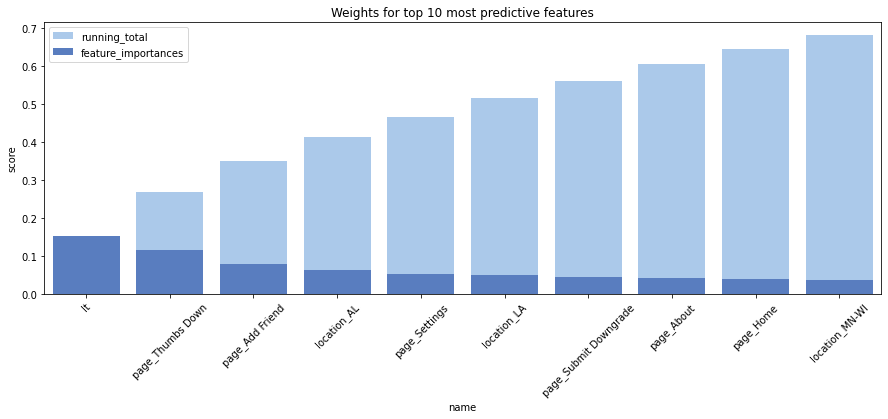

In [82]:
# plot top 10 important features
fp=ExtractFeatureImp(model.bestModel.featureImportances)
# plot running total
sns.set_color_codes('pastel')
sns.barplot(data=fp[:10],x='name',y='running_total',label='running_total',color='b')
# plot individual score
sns.set_color_codes('muted')
sns.barplot(data=fp[:10],x='name',y='score',label='feature_importances',color='b')
plt.legend(loc=0)
plt.title('Weights for top 10 most predictive features')
plt.xticks(rotation=45);

In [83]:
# top 30 features
fp[:30]

,idx,name,score,running_total
66,66,lt,0.152625,0.152625
82,82,page_Thumbs Down,0.117122,0.269746
69,69,page_Add Friend,0.079867,0.349613
1,1,location_AL,0.063086,0.412699
79,79,page_Settings,0.052094,0.464793
18,18,location_LA,0.050963,0.515756
80,80,page_Submit Downgrade,0.044223,0.559979
68,68,page_About,0.044016,0.603995
74,74,page_Home,0.039029,0.643024
23,23,location_MN-WI,0.036954,0.679978


###### Statistical property of features

In [96]:
final_df.createOrReplaceTempView('summary')
featuresum=spark.sql('''
select label churn, avg(lt) avg_life_time, avg(`page_Thumbs Down`) avg_dislike, avg(`page_Add Friend`) avg_friends, 
            avg(location_AL) avg_AL_counts, avg(page_Settings) avg_setting, avg(location_LA) avg_LA_counts,
            avg(`page_Submit Downgrade`) avg_downgrade, avg(`page_About`) avg_About_page, 
            avg(page_Home) avg_Home_page, avg(`location_MN-WI`) avg_MW_WI_count
from summary
group by 1''').toPandas()

In [97]:
featuresum

,churn,avg_life_time,avg_dislike,avg_friends,avg_AL_counts,avg_setting,avg_LA_counts,avg_downgrade,avg_About_page,avg_Home_page,avg_MW_WI_count
0,0,7.484022e+09,11.849711,21.046243,0.011561,7.190751,0.005780,0.312139,2.537572,48.612717,0.017341
1,1,4.951238e+09,9.538462,12.230769,0.038462,5.192308,0.019231,0.173077,1.076923,32.153846,0.000000


In [98]:
# reformat df for plotting purpose
fs_df=featuresum.groupby(['churn'])[featuresum.columns[1:]].max().unstack().reset_index()
fs_df.rename(columns={'level_0':'features',0:'values'},inplace=True)

In [201]:
#fs_df

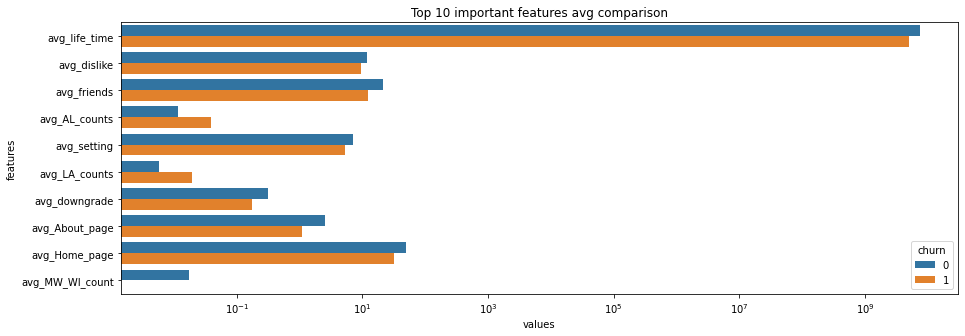

In [100]:
sns.barplot(data=fs_df,y='features',x="values",hue='churn')
plt.xscale('log')
plt.title('Top 10 important features avg comparison');

###### Dimension reduction
The original dataframe `final_df` has 83 features, we can see from the  `Weights for top 10 most predictive features` plot that 10 features already carry well over 60% of weights. Futhermore, `fp` dataframe shows 30 features carry over 98% of weights. 

Reducing dimension to top 30 features will be cheaper in terms of time consume and computing power while model still remains promising output.

In [174]:
def featurereduction(num=30):
    '''
    function to compare time consume and f1 socre between full feature model and reduced feature model.
    features are sorted in descending order by feature importance
    input: num- number of feautres to keep
    output: a comparative dataframe'''
    # set up df comlumns
    featurenum=[82,num]
    f1s=[]
    duration=[]

    # set up model with best estimator
    gbt_best=GBTClassifier(maxDepth=5,maxIter=10)
    # set up evaluator
    evaluator=MulticlassClassificationEvaluator()
    
    # full dataset 82 features
    time0=time.time()
    full_model=gbt_best.fit(train)
    pre_full=full_model.transform(test)
    # get f1 and time
    endtime=time.time()-time0
    f1_tuned=evaluator.evaluate(pre_full)
    f1s.append(f1_tuned)
    duration.append(endtime)
    
    # reduce feature data set
    # re assemb and scale
    reduce_assembler=VectorAssembler(inputCols=[ml_df.columns[2:][i] for i in fp['idx'][:num].values],outputCol="vector")
    reduce_df=reduce_assembler.transform(ml_df)
    reduce_scaler=MinMaxScaler(inputCol='vector',outputCol='features')
    reduce_df=reduce_scaler.fit(reduce_df).transform(reduce_df)

    # resplit data
    reduce_train,reduce_test=reduce_df.randomSplit([.8,.2],seed=42)
    gbt_best=GBTClassifier(maxDepth=5,maxIter=10)
    time0=time.time()
    # Train on the "best" model found from grid search earlier
    reduce_model=gbt_best.fit(reduce_train)
    # Make new predictions
    reduced_predictions=reduce_model.transform(reduce_test)
    # duration
    reduc_time=time.time()-time0
    # evaluation
    f1_reduce=evaluator.evaluate(reduced_predictions)
    f1s.append(f1_reduce)
    duration.append(reduc_time)
    
    # make df
    dfdict={'feature_num':featurenum,
           'f1_score':f1s,
           'duration':duration}
    return pd.DataFrame(dfdict)

In [175]:
com=featurereduction()
com

,feature_num,f1_score,duration
0,82,0.744187,78.416440
1,30,0.767482,68.693063


In [187]:
f1=100*((com['f1_score'][1]-com['f1_score'][0])/com['f1_score'][0])
time=100*((com['duration'][0]-com['duration'][1])/com['duration'][0])

In [190]:
print("F1 increase {:.2f}%".format(f1))
print("Time reduce {:.2f}%".format(time))

F1 increase 3.13%
Time reduce 12.40%


# Final Steps
###### Reflection

Since the churned users are a fairly small subset, the data is imbalanced, using F1 score as the metric is the fair call.

A quick summary of our initial models:
* Random Forest F1 score 0.6410174880763115.
* GBT F1 score 0.7456568331672422.
* Linear SVC F1 score 0.625548726953468.

Because GBT outperformed other two model, I choose it as the base model. After tuning parameters the best model reached over 0.74 as f1 score. Parameters specification:
* maxDepth: 5
* maxIter: 10

I extracted the feature importance from the tuned model and plotted the top 10 most important features. We can see the most important feature carrys over 15% weights is `customer lifetime`.
$$customer\ lifetime=max(ts)- registration$$

This is a very import metric as it is part of many KIP formulas. (e.g. LTV, ARPU, Churn rate). Moving on with the plot, other features indicates page landed or locations. Total accumulated weight of 10 features is well over 60%.
For a better understatement of these 10 features we will take a look at `Top 10 important features avg comparison` plot. We can clearly see some behavioral characteristics.

Users who stayed tend to have higher average ratios on app interactive features. E.g. long customer life time, higher page landing ratios including downgrade pages. They generally spend more time to play musics, setting up or customize their accounts.

On the other hand, users who churned have higher ratios on geographic features. This might indicate our user is geographic biased. We could consider run promotions and other marketing strategies to increase customer retention.

For the last part, I extracted top 30 features from feature importance, train two models both based on the same best parameters we found through tuning process, but one model with full data set while another model with only 30 features. Comparing both time consumed as well as f1 scores. 

As we may have expected, feature reduced model take less time to train and predict, it decreased time 12.4% than full feature model. Surprisingly, feature reduced model also increase f1 score by a small amount of 3.13%. This is a classical example of bias-variance tradeoff. More feature yield a better performance on training set, as it generalizing worse on the test set. In other words the full feature model might suffer from overfitting.

###### Improvement
One factor we overlooked is data set imbalance. That is: amount of churned and amount of stayed is highly different. Detailed statistics shown below.

In [192]:
final_df.createOrReplaceTempView("ml")
spark.sql('''
select label Churn, count(distinct userId) user_amount 
from ml
group by 1''').show()

+-----+-----------+
|Churn|user_amount|
+-----+-----------+
|    0|        173|
|    1|         52|
+-----+-----------+



Churn stayed ratio is roughly 1:3.3. This could output over optimistic accuracy score and poor f1 score because algorithms optimize accuracy by default. In this case we might need to consider resample techniques to correct imbalance (e.g. oversample minority, undersample majority, SMOTE...)

Another straightforward way to improve model performance is to simply add more hyper parameters options during the grid search step. The trad-off though is dramatically increased time consumption as well as computing power need.

Finally, referring back to when we defined churns, we considered a user churn only when they cancel their account. In real life scenario we would also take downgrade action into count. When a user downgrade their account from paid user to free user means the user is not profitable anymore, this is another way of churn. However, this kind of churn leads to a more complex case when a user upgrade their account back to paid user again later. Further study is needed to address this problem.